## Script to plot domain and elevation from geo_em.d01.nc file
This is an example for EPICC experiments
This script uses cartopy package for plotting maps

Loading modules required

In [1]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import wrf
import string

from copy import copy

%matplotlib inline
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom

In [2]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

Importing geo_em.d01.nc file and variables
Setting map limits and projection based on the input wrf file

In [3]:
#getting geographical info for plotting
geo_filename = './geo_em.d01.EPICC_2km_ERA5_HVC_GWD.nc'
geo_file = xr.open_dataset(geo_filename)
geo_file_lm = geo_file.HGT_M.squeeze()
xbounds = wrf.cartopy_xlim(wrfin=nc.Dataset(geo_filename))
ybounds = wrf.cartopy_ylim(wrfin=nc.Dataset(geo_filename))
geo_proj = wrf.get_cartopy(wrfin=nc.Dataset(geo_filename))

lats = geo_file.XLAT_M.squeeze().values
lons = geo_file.XLONG_M.squeeze().values

/Users/daniel/opt/anaconda3/envs/py385/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/daniel/opt/anaconda3/envs/py385/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/daniel/opt/anaconda3/envs/py385/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
<ipython-input-2-174b4ae62473>:36: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.to

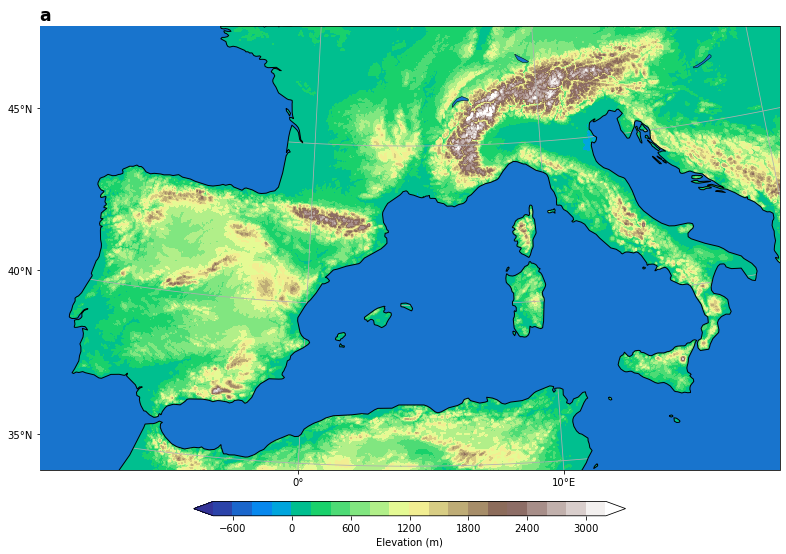

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1,projection=geo_proj)
ax.set_title(f'{string.ascii_lowercase[0]}',loc='left',fontsize='xx-large',fontweight='bold')
ax.coastlines(linewidth=1,zorder=102,resolution='50m')
ct=ax.contourf(lons,lats,geo_file_lm,levels=np.arange(-800,3400,200),cmap='terrain',extend='both',transform=ccrs.PlateCarree())
#gl=ax.gridlines(crs=ccrs.PlateCarree(), xlocs=range(-180,181,5), ylocs=range(-80,81,5),
#                 draw_labels=True, zorder=102,
#                 linewidth=0.2, color='k', alpha=1, linestyle='-')

oce50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
lakes50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m')

ax.add_feature(oce50m , zorder=100,facecolor=[24/255,  116/255,  205/255])
ax.add_feature(lakes50m, zorder=100,linewidth=0.5,edgecolor='k',facecolor=[24/255,  116/255,  205/255])

# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-110, -50, -40, -30, -20, -11, 0, 10, 20, 30, 40, 50]
yticks = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
ax.gridlines(xlocs=xticks, ylocs=yticks)

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)

# Set the map bounds
ax.set_xlim(xbounds)
ax.set_ylim(ybounds)

# Adding colorbar

cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
cbar=plt.colorbar(ct, cax=cbar_ax,orientation="horizontal")
cbar.set_label ('Elevation (m)')
fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.18,wspace=0.1,hspace=0.5)

